In [6]:
import os
import sys
import importlib
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import tqdm
from joblib import Parallel, delayed
import spatialdm as sdm

In [2]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import model2
import simulation

In [75]:
import importlib
importlib.reload(model2)

<module 'model2' from '/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py'>

## Extract LR pairs using SDM

In [4]:
adata = sq.datasets.visium(sample_id='V1_Breast_Cancer_Block_A_Section_1')
annotation_meta = pd.read_csv(
    'data/Human_Breast_Cancer_Metadata.tsv',
    sep = '\t',
    index_col=0
)
adata.obs = adata.obs.join(annotation_meta)
adata.var_names_make_unique()

In [7]:
adata_sdm = adata.copy()
sdm.extract_lr(adata_sdm, 'human', min_cell=20)
adata.obs['celltype'] = adata.obs.annot_type

## Sparsity level of extracted LR pairs

In [9]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata_sdm, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_lr = adata.to_df().loc[:,chosen_lr]
percent = np.count_nonzero(count_lr,0).mean() / np.shape(count_lr)[0]
print(f"Total non-zero counts {percent*100:.2f}%")

Total non-zero counts 25.48%


## Count matrix

In [11]:
count_df = adata.to_df()

## Create spatial network

In [14]:
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata,
    force_recalculate=True,
    distance_aware=False
)

Constructing spatial network with visium


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3798/3798 [00:00<00:00, 18217.86it/s]


## Create a dataset

In [16]:
data_list_dict, umi_sums, dist_list_dict, data_list_dict_selfloop, umi_sums_selfloop, dist_list_dict_selfloop = \
spatial.prepare_data_list_for_visium(
    count_df,
    int_edges_with_selfloop,
    lig_rec_info_df=adata_sdm.uns['geneInter'],
    heteromeric=True,
    lig_df=adata_sdm.uns['ligand'],
    rec_df=adata_sdm.uns['receptor'],
    summarization='sum',
    separate_lig_rec_type=True
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


## Run copula for Tumor → Surrounding tumor (For quick result run for one pair of groups)

In [17]:
lig_rec_info_df=adata_sdm.uns['geneInter'].copy()
close_contact_index = []
other_index = []
for index,row in lig_rec_info_df.iterrows():
    if row.annotation == 'Cell-Cell Contact':
        close_contact_index += [index]
    else:
        other_index += [index]

In [18]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
opt_params = opt_params._replace(num_starts=50)

cop_df_dict = model2.run_copula(
    data_list_dict,
    umi_sums,
    df_lig_rec_index=other_index,
    groups=['Tumor=Surrounding tumor'],
    n_jobs=20,
    heteronomic=True,
    use_zero_cutoff=True,
    use_length_cutoff=True,
    copula_params=copula_params,
    opt_params=opt_params
)

Tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:324: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   21.9s
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:324: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:324: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:324: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:324: RuntimeWarning: divide by zero encountered in log
  mu_x_start = np.log(x.sum() / umi_sum_1.sum())
[Parallel(n_jobs=20)]: Done 160 tasks      | elapse

In [56]:
copula_df = cop_df_dict['Tumor=Surrounding tumor']

### Calculate p-values

In [82]:
# Download from https://drive.google.com/drive/u/0/folders/1MtenBN2spAvCxa27y3T6suxphJPC3oO9

permutation_df = pd.read_csv(
    os.path.join(
    '/Users/hs0424/Workspace/copulacci/notebook/'
    'orator_paper_notebook/ISMB_submission_notebooks/',
    'BRCA_visium/copula_results/',
    'permutation_data_frame_Tumor=Surrounding tumor.csv'
    
))


In [57]:
copula_df = copula_df.reset_index().rename(columns = {'index' : 'LR_index'})

In [58]:
copula_df.loc[:, 'pval'] = 1.0

In [59]:
copula_df.head()

,LR_index,copula_coeff,mu_x,mu_y,copula_method,pval
0,COL4A4_ITGA9_ITGB1,0.000000,-15.819865,-8.233241,skip_zero_cutoff,1.0
1,COL6A1_ITGA9_ITGB1,0.103003,-8.817694,-8.234218,copula,1.0
2,COL6A2_ITGA9_ITGB1,0.018371,-8.473260,-8.234098,copula,1.0
3,COL4A3_ITGA9_ITGB1,0.000000,-15.819865,-8.233241,skip_zero_cutoff,1.0
4,COL6A3_ITGA9_ITGB1,0.056685,-9.345295,-8.234934,copula,1.0


In [63]:
for index, row in tqdm.tqdm(copula_df.iterrows()):
    if row.LR_index in permutation_df.columns:
        lr_exp = permutation_df[row.LR_index].values
        I = row.copula_coeff
        bg = np.append(lr_exp, I)
        pval = np.sum(abs(bg) > abs(I))/len(bg)
        copula_df.loc[index, 'pval'] = pval

1050it [00:00, 13494.07it/s]


## Run SCC for Tumor → Surrounding tumor (For quick result run for one pair of groups)

In [65]:
adata_scc = adata.copy()
scc_df_dict = model2.run_scc(
    adata_scc,
    adata_sdm.uns['geneInter'],
    int_edges_new,
    groups=['Tumor=Surrounding tumor'],
    lig_df=adata_sdm.uns['ligand'],
    rec_df=adata_sdm.uns['receptor'],
    n_jobs=20,
    verbose=1,
    heteronomic=True,
    add_pval=True,
    use_spatialdm=True
)

Tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:738: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   13.4s
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:738: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:738: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:738: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py:738: RuntimeWarning: invalid value encountered in double_scalars
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   18.4s
/Users/hs0424/Workspace/copulacci/src/c

## Run SDM for Tumor → Surrounding tumor (For quick result run for one pair of groups)

In [67]:
sdm_df_dict = model.run_sdm(
    adata,
    int_edges_new,
    groups = ['Tumor=Surrounding tumor'],
    nproc = 20,
    heteronomic=True
)

Tumor=Surrounding tumor
DiGraph with 244 nodes and 234 edges
(244, 36601)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:171: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Tumor=Surrounding tumor  is  43.09043097496033  seconds


## Merge results

In [68]:
copula_df.head()

,LR_index,copula_coeff,mu_x,mu_y,copula_method,pval
0,COL4A4_ITGA9_ITGB1,0.000000,-15.819865,-8.233241,skip_zero_cutoff,1.000000
1,COL6A1_ITGA9_ITGB1,0.103003,-8.817694,-8.234218,copula,0.005988
2,COL6A2_ITGA9_ITGB1,0.018371,-8.473260,-8.234098,copula,0.548902
3,COL4A3_ITGA9_ITGB1,0.000000,-15.819865,-8.233241,skip_zero_cutoff,1.000000
4,COL6A3_ITGA9_ITGB1,0.056685,-9.345295,-8.234934,copula,0.139721


In [69]:
tmp1 = scc_df_dict['Tumor=Surrounding tumor'].copy()
tmp2 = sdm_df_dict['Tumor=Surrounding tumor'].copy()
tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')

res = copula_df.set_index('LR_index').join(tmp3, how='inner')

## Keep the intersection

In [73]:
res = res.loc[res.copula_method == 'copula'].copy()

In [77]:
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))
import plots2

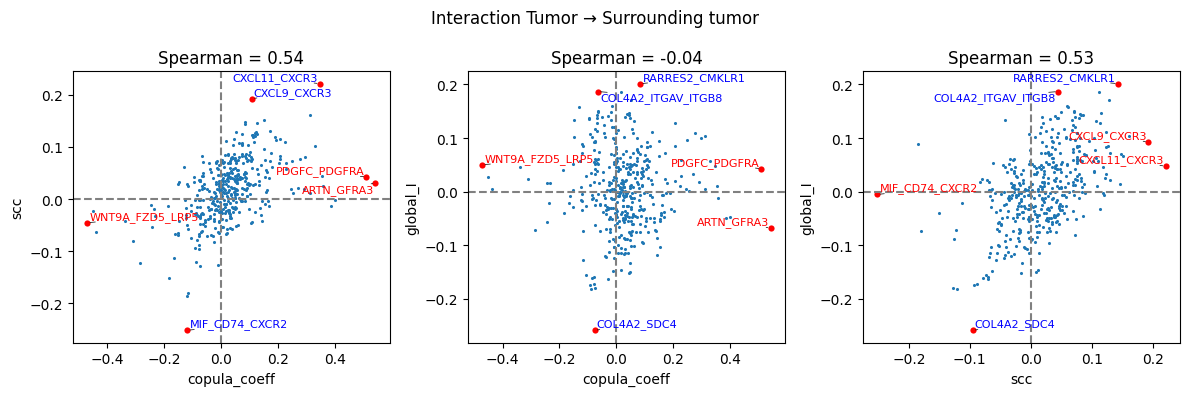

In [81]:
plots2.draw_pairwise_scatter(
    res,
      'Tumor=Surrounding tumor',
      score_pair,
      bimod_filter=False,
    s = 5,
    ntop=3,
    #only_pos=True
)

In [84]:
adata.obsm['spatial']

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [89]:
importlib.reload(model2)

<module 'model2' from '/Users/hs0424/Workspace/copulacci/src/copulacci/model2.py'>

In [101]:
import warnings
gpair = 'Tumor=Surrounding tumor'
umi_sums_1 = umi_sums[gpair]['Tumor']
umi_sums_2 = umi_sums[gpair]['Surrounding tumor']
for i,(x,y) in enumerate(data_list_dict[gpair]):
    if (x.sum() == 0 or y.sum() == 0):
        print('x or y is zero')
    with warnings.catch_warnings(record=True) as w:
        sx = np.log(x.sum() / umi_sums_1.sum())
        sy = np.log(y.sum() / umi_sums_2.sum())
        if w:
            print(i, sx, sy)
            break

x or y is zero
6 -inf -8.23324133561905


In [150]:
copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
opt_params = opt_params._replace(num_starts=50)

cop_df_dict_stability = model2.run_copula(
    data_list_dict,
    umi_sums,
    df_lig_rec_index=other_index,
    groups=['Tumor=Surrounding tumor'],
    n_jobs=20,
    heteronomic=True,
    use_zero_cutoff=False,
    use_length_cutoff=False,
    stability_filter=True,
    copula_params=copula_params,
    opt_params=opt_params
)

Tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   17.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  2.8min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  3.9min
[Parallel(n_jobs=20)]: Done 1050 out of 1050 | elapsed:  5.0min finished


In [158]:
tmp5 = cop_df_dict_stability['Tumor=Surrounding tumor']

In [159]:
tmp5.copula_method.value_counts()

copula_method
copula                   643
skip_stability_filter    378
all_zero                  29
Name: count, dtype: int64

In [160]:
tmp5[['copula_coeff', 'copula_method']]

,copula_coeff,copula_method
COL4A4_ITGA9_ITGB1,0.038177,copula
COL6A1_ITGA9_ITGB1,0.102977,copula
COL6A2_ITGA9_ITGB1,0.018375,copula
COL4A3_ITGA9_ITGB1,0.037977,copula
COL6A3_ITGA9_ITGB1,0.056710,copula
...,...,...
CCL3_CCR5,0.364466,copula
CCL5_CCR5,0.138518,copula
CCL4_CCR5,0.087439,copula
CXCL1_ACKR1,0.000000,skip_stability_filter


In [117]:
res2 = res.join(tmp5[['copula_coeff', 'copula_method']], rsuffix='_stable')

In [120]:
res2 = res2.rename(columns = {'copula_coeff': 'copula_coeff_vanilla', 
                       'copula_method':'copula_coeff_vanilla',
                       'copula_coeff_stable' : 'copula_coeff',
                       'copula_method_stable' : 'copula_method'
                      })

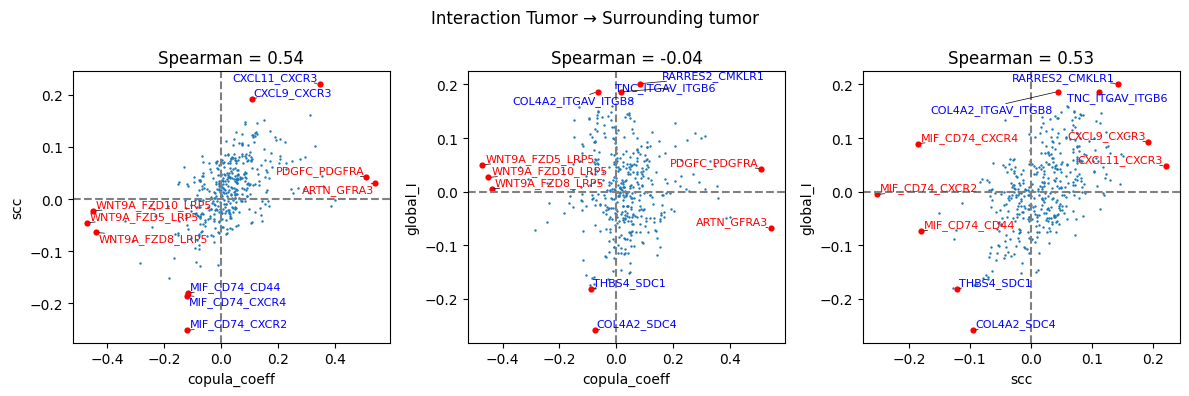

In [143]:
plots2.draw_pairwise_scatter(
    res,
      'Tumor=Surrounding tumor',
      score_pair,
      bimod_filter=False,
    s = 3,
    ntop=5,
    center_plot=False
    #only_pos=True
)

In [133]:
importlib.reload(plots2)

<module 'plots2' from '/Users/hs0424/Workspace/copulacci/src/copulacci/plots2.py'>

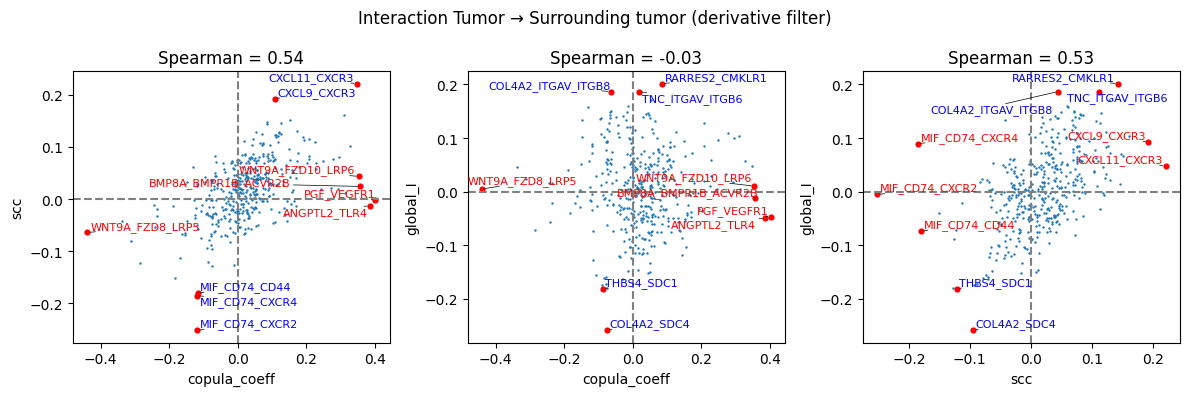

In [142]:
plots2.draw_pairwise_scatter(
    res2,
      'Tumor=Surrounding tumor (derivative filter)',
      score_pair,
      bimod_filter=False,
    s =3,
    ntop=5,
    center_plot=False
    #only_pos=True
)

## Exclusively merge with cop_df_dict_stability['Tumor=Surrounding tumor']

In [161]:
copula_df_stable = cop_df_dict_stability['Tumor=Surrounding tumor'].join(copula_df.set_index('LR_index')[['pval']]).copy()

In [162]:
tmp1 = scc_df_dict['Tumor=Surrounding tumor'].copy()
tmp2 = sdm_df_dict['Tumor=Surrounding tumor'].copy()
tmp3 = tmp1.join(tmp2[['global_I', 'global_pval']], how='inner')

res3 =  copula_df_stable.join(tmp3, how='inner')

In [163]:
res3.loc[res3.copula_method == 'copula']

,copula_coeff,mu_x,mu_y,copula_method,pval,scc,scc_pval,global_I,global_pval
COL6A1_ITGA9_ITGB1,0.102977,-8.817711,-8.234215,copula,0.005988,0.028647,0.560878,-0.054004,1.000000e+00
COL6A2_ITGA9_ITGB1,0.018375,-8.473285,-8.234046,copula,0.548902,-0.067361,0.151697,-0.113926,1.000000e+00
COL6A3_ITGA9_ITGB1,0.056710,-9.345337,-8.234968,copula,0.139721,0.040706,0.483034,-0.018661,1.000000e+00
COL4A5_ITGA9_ITGB1,0.022245,-11.175817,-8.233721,copula,0.700599,0.084547,0.109780,-0.000249,9.918792e-01
LAMA4_ITGA9_ITGB1,0.006016,-11.083663,-8.233415,copula,0.890220,0.013818,0.780439,-0.114397,1.000000e+00
...,...,...,...,...,...,...,...,...,...
CCL19_ACKR4,0.082214,-10.979443,-12.604926,copula,1.000000,0.022360,0.702595,0.026357,3.243097e-11
CCL19_CCR7,0.166530,-10.978157,-11.810470,copula,1.000000,0.055222,0.273453,0.001938,6.026611e-01
CCL3_CCR5,0.364466,-11.151541,-11.622344,copula,1.000000,0.089016,0.067864,0.008358,3.546057e-02
CCL5_CCR5,0.138518,-10.104096,-11.671209,copula,1.000000,0.120551,0.023952,0.017277,1.408290e-05


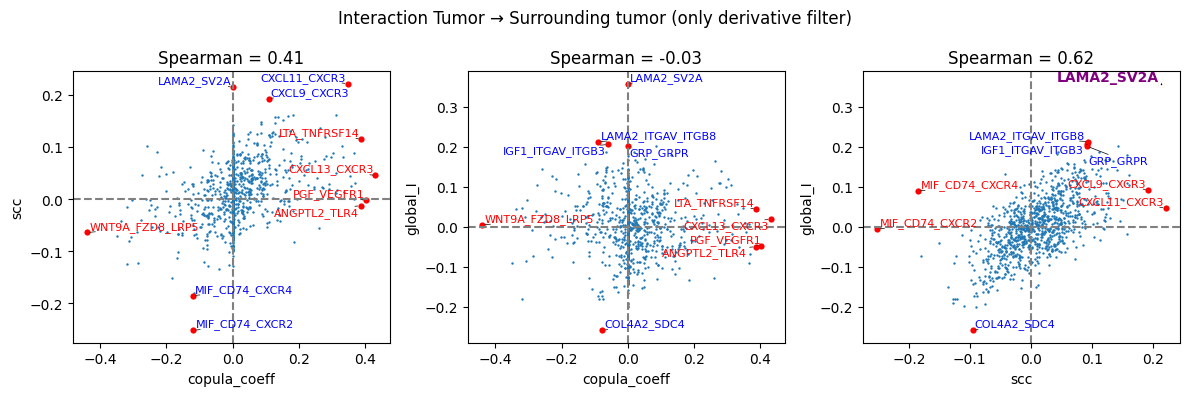

In [164]:
plots2.draw_pairwise_scatter(
    res3,
     'Tumor=Surrounding tumor (only derivative filter)',
      score_pair,
      bimod_filter=False,
    s = 3,
    ntop=5,
    center_plot=False
    #only_pos=True
)

In [224]:
importlib.reload(plots2)

<module 'plots2' from '/Users/hs0424/Workspace/copulacci/src/copulacci/plots2.py'>

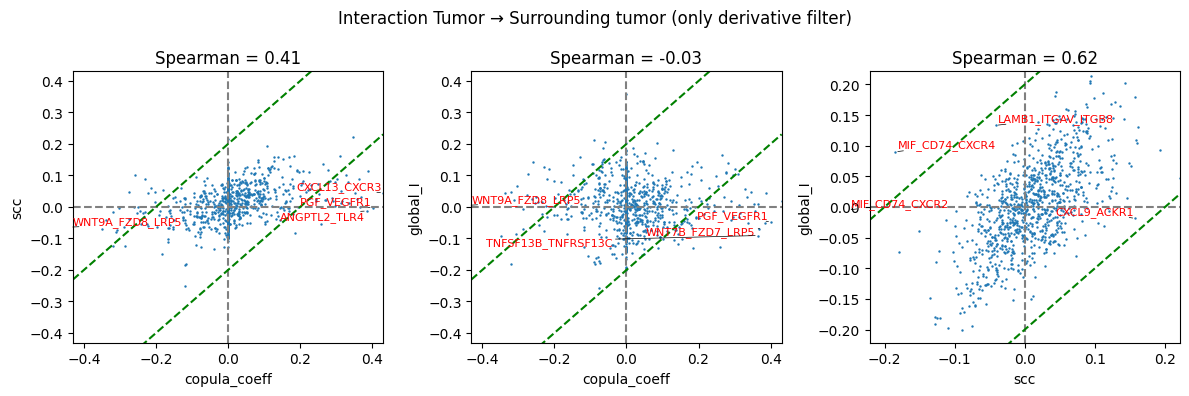

In [227]:
plots2.draw_pairwise_difference_scatter(
    res3,
     'Tumor=Surrounding tumor (only derivative filter)',
      score_pair,
      bimod_filter=False,
    s = 3,
    ntop=4,
    center_plot=True
    #only_pos=True
)